In [1]:
!pip install eofs
!pip install gpflow
!pip install cartopy
!pip install utils
# iske bina cartopy crash karega
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100355 sha256=25092c793077c31d187ebf97136e68220b5722ff0e6d02bef1e79e9665b7c025
  Stored in directory: /root/.cache/pip/wheels/3d/69/36/c8bd247900ab5ade980a418ac2faed41e08f5006f7c369282f
Successfully built eofs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.0 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp31

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

In [3]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
import numpy as np
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
# data_path = './data/train_val/'
data_path = "/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/"

min_co2 = 0.
max_co2 = 9500
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.8
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4


def create_predictor_data(data_sets, n_eofs=5):
    """
    Args:
        data_sets list(str): names of datasets
        n_eofs (int): number of eofs to create for aerosol variables
    """

    # Create training and testing arrays
    X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time',coords='minimal')
    X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)
#     print(bc_pcs.to_dataframe())
    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs, (so2_solver, bc_solver)


def get_test_data(file, eof_solvers, n_eofs=5):
    """
    Args:
        file str: name of datasets
        n_eofs (int): number of eofs to create for aerosol variables
        eof_solvers (Eof_so2, Eof_bc): Fitted Eof objects to use for projection
    """

    # Create training and testing arrays
    X = xr.open_dataset(data_path + f"inputs_{file}.nc")

    so2_pcs = eof_solvers[0].projectField(X["SO2"], neofs=5, eofscaling=1)
    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    bc_pcs = eof_solvers[1].projectField(X["BC"], neofs=5, eofscaling=1)
    bc_df = so2_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)
    return inputs


def create_predictdand_data(data_sets):
    Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400
    return Y


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth - pred)**2).weighted(weights).mean(['lat', 'lon'])).data

In [5]:
#prepare data

# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [6]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_pr90 = create_predictdand_data(train_files)['pr90'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr90_truth = 86400 * Y_test["pr90"].mean('member')

In [7]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr90 = y_train_pr90[~nan_train_mask]
assert len(X_train) == len(y_train_pr90)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr90_truth = pr90_truth[~nan_test_mask]

In [8]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [9]:
# Standardize predictand fields
train_pr90_mean, train_pr90_std = y_train_pr90.mean(), y_train_pr90.std()
y_train_pr90 = (y_train_pr90 - train_pr90_mean) / train_pr90_std

In [10]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

In [11]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64),
                                y_train_pr90.astype(np.float64)),
                                kernel=kernel,
                                mean_function=mean)

In [12]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=35))

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 13981657.577141833
        x: [ 5.176e+00  3.007e-01 ...  2.565e-01 -1.684e-02]
      nit: 35
      jac: [ 2.587e+02  1.028e+03 ... -1.153e+04 -7.191e+02]
     nfev: 37
     njev: 37
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

In [13]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr90_std + train_pr90_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr90_std

In [14]:

# put output back into xarray format for calculating RMSE/plotting
posterior_pr90 = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr90_std = np.reshape(posterior_std, [86, 96, 144])
posterior_pr90_data = xr.DataArray(posterior_pr90, dims=pr90_truth.dims, coords=pr90_truth.coords)
posterior_pr90_std_data = xr.DataArray(posterior_pr90_std, dims=pr90_truth.dims, coords=pr90_truth.coords)

In [15]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr90_truth[35], posterior_pr90_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr90_truth[85], posterior_pr90_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr90_truth[30:41], posterior_pr90_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr90_truth[75:], posterior_pr90_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr90_truth[35:], posterior_pr90_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(pr90_truth[-20:].mean(dim='time'), posterior_pr90_data[-20:].mean(dim='time'))}")

RMSE at 2050: 1.3199672988972655
RMSE at 2100: 1.6311030812901472
RMSE 2045-2055: 1.5059653418619503
RMSE 2090-2100: 1.5004691816810536
RMSE 2050-2100: 1.5300902317765885
RMSE average last 20y: 0.41507468999090447


[Text(0.5, 1.0, 'Difference')]

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


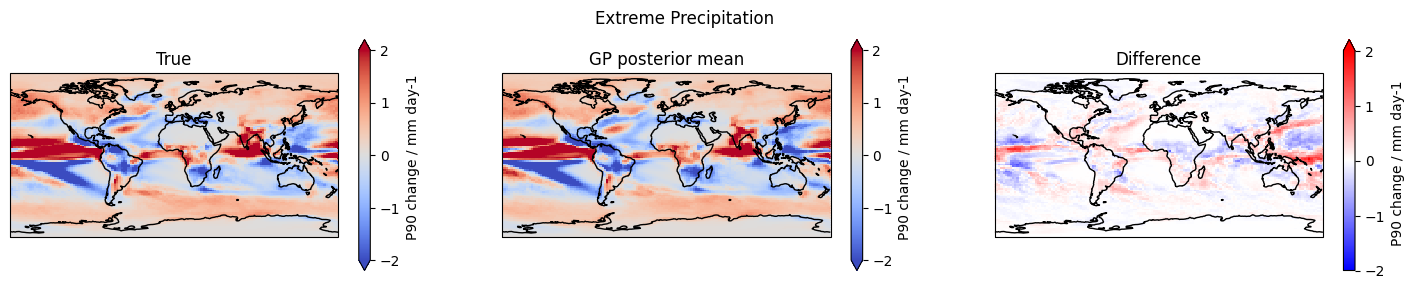

In [16]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Extreme Precipitation')

# Test
plt.subplot(131, projection=proj)
pr90_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr90_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr90_truth - posterior_pr90_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [17]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.01684]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.85473
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,5.18163
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.0001
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,8.7753
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.07209
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[3.18397, 6.92961, 5.73099..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.02568
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1.90036, 2.40945, 3.32326..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.82957


In [18]:
# Save predictions
posterior_pr90_data.to_netcdf('/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/climatebench-gp-posterior-mean-pr90-test-2019-2100.nc')
posterior_pr90_std_data.to_netcdf('/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/climatebench-gp-posterior-std-pr90-test-2019-2100.nc')